In [55]:
import pandas as pd
from sodapy import Socrata
import numpy as np

In [70]:
client = Socrata("datahub.transportation.gov", 'iS5laersRc93IyBG0E5hMBsG9')

results = client.get("6axg-epim", limit=1000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

HTTPError: 503 Server Error: Service Temporarily Unavailable

In [75]:
# df = df.drop(['recall_link','mfr_campaign_number'],axis=1)
## replacing nan values in the completion_rate columns with 0
df['completion_rate'] = df['completion_rate'].fillna(0)
## dropping irrelavant columns
##extracting timeseries object
df['report_received_date'] = pd.to_datetime(df['report_received_date'])
df['report_received_date'] = df['report_received_date'].dt.strftime('%Y-%m')
df

,report_received_date,nhtsa_id,manufacturer,subject,component,recall_type,potentially_affected,defect_summary,consequence_summary,corrective_action,fire_risk_when_parked,do_not_drive,completion_rate
0,2023-12,23V837000,Mazda North American Operations,Replacement Air Bag Inflator Incorrectly Insta...,AIR BAGS,Vehicle,12741,Mazda North American Operations (Mazda) is rec...,An incorrectly installed inflator may not prop...,Dealers will inspect and reinstall the front p...,No,No,0
1,2023-12,23V839000,Great Dane Trailers,Loose Axle Spindle Nut May Cause Wheel Detachment,SUSPENSION,Vehicle,346,Great Dane Trailers (Great Dane) is recalling ...,A loose axle spindle nut can allow the wheel t...,Great Dane will inspect and tighten the axle s...,No,No,0
2,2023-12,23V838000,"Tesla, Inc.",Autopilot Controls Insufficient to Prevent Misuse,ELECTRICAL SYSTEM,Vehicle,2031220,"Tesla, Inc. (Tesla) is recalling 2012-2023 Mod...",In certain circumstances when Autosteer is eng...,Tesla will release an over-the-air (OTA) softw...,No,No,0
3,2023-12,23V835000,"Mercedes-Benz USA, LLC",Improperly Secured 12-Volt Ground Connection,ELECTRICAL SYSTEM,Vehicle,164,"Mercedes-Benz USA, LLC (MBUSA) is recalling ce...",An overheated ground connection can increase t...,Dealers will inspect and secure the 12-Volt gr...,No,No,0
4,2023-12,23V836000,Harley-Davidson Motor Company,Motorcycle Difficult to Control at High Speeds,ENGINE AND ENGINE COOLING,Vehicle,1464,Harley-Davidson Motor Company (Harley-Davidson...,A motorcycle that is difficult to control can ...,Dealers will update the engine control module ...,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-12,22V894000,"Old School Trailers, LLC",Awning Fabric May Detach Causing Awning to Drop,EQUIPMENT,Vehicle,16,"Old School Trailers, LLC (Old School Trailers)...",An awning that drops or extends beyond normal ...,The remedy is still under development. Owner n...,No,No,6.25
996,2022-12,22V892000,Pierce Manufacturing,Tie Rod Clamp Failure,STEERING,Vehicle,17,Pierce Manufacturing (Pierce) is recalling cer...,Tie rod separation can result in a sudden loss...,"Dealers will replace the tie rod clamps, free ...",No,No,90.91
997,2022-12,22V890000,Newmar Corporation,Steering Wheel Separation,STEERING,Vehicle,30,Newmar Corporation (Newmar) is recalling certa...,Separation of the steering wheel could result ...,Dealers will install new steering wheel cap sc...,No,No,56.67
998,2022-12,22V891000,Entegra Coach,Insufficient Air Brake Supply Volume/FMVSS 121,"SERVICE BRAKES, AIR",Vehicle,394,Entegra Coach (Entegra) is recalling certain 2...,The undersized air brake supply reservoir may ...,"Dealers will replace the air reservoir, free o...",No,No,0


In [58]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

numerical_features = df[['potentially_affected', 'completion_rate']]
euclidean_dist = euclidean_distances(numerical_features)

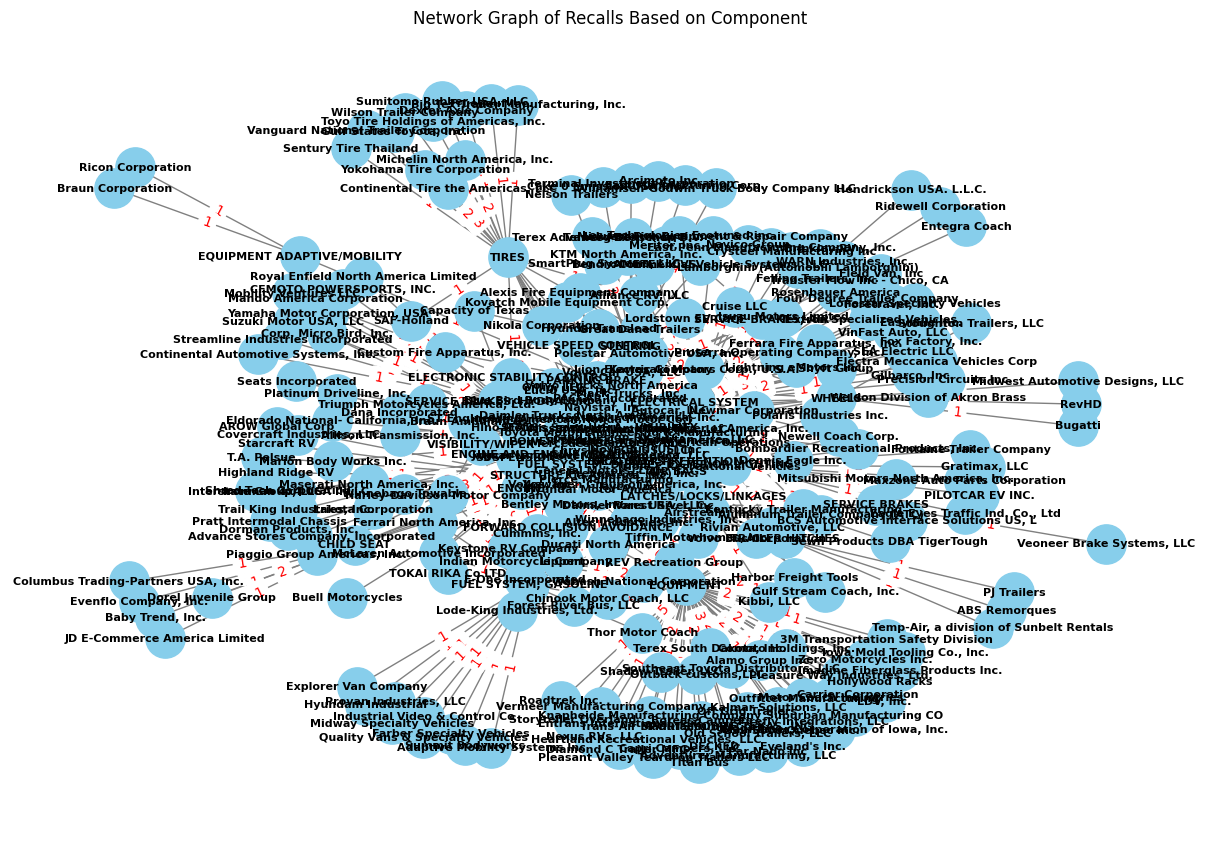

In [59]:
import networkx as nx
G = nx.Graph()

for index, row in df.iterrows():
    G.add_node(row['component'])
    
    if G.has_edge(row['component'], row['manufacturer']):
        G[row['component']][row['manufacturer']]['weight'] += 1  
    else:
        G.add_edge(row['component'], row['manufacturer'], weight=1)  

# Draw the network graph
pos = nx.spring_layout(G)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, font_size=8, node_color='skyblue', node_size=800, font_color='black', font_weight='bold', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title('Network Graph of Recalls Based on Component')
plt.show()
nx.write_graphml(G,'recallsbasedoncomponent.graphml')

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

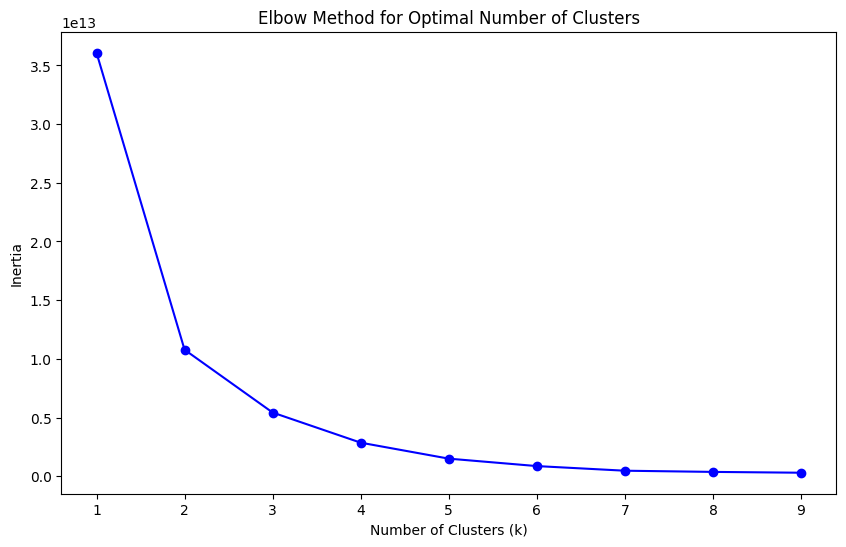

In [60]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

features_for_clustering = df[['potentially_affected', 'completion_rate']]

inertia_values = []
possible_k_values = range(1, 10)  

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_for_clustering)
    inertia_values.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/cs/j8zp0cms6vq0cmpk_cyy1kn00000gn/T/ipykernel_39068/607736632.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df, palette='viridis')


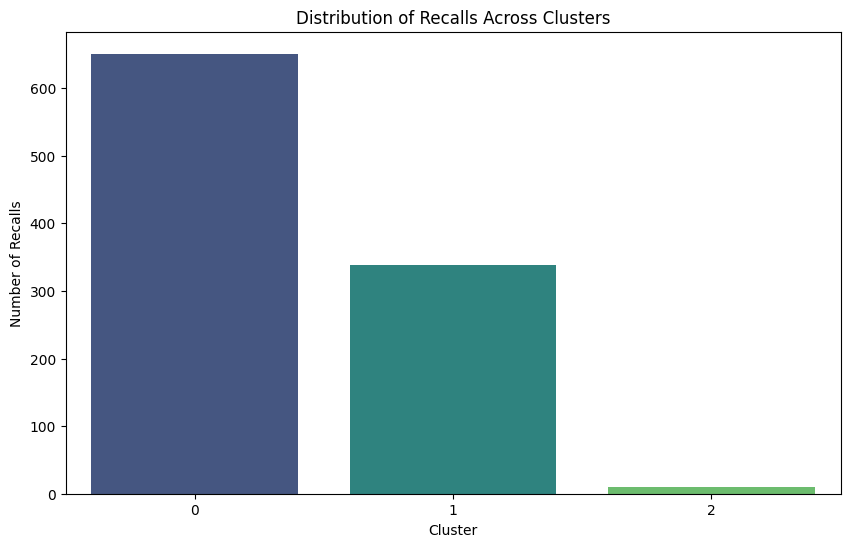

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df['potentially_affected'] = df['potentially_affected'].astype(int)
df['completion_rate'] =  df['completion_rate'].astype(float)

df['risk_score'] =1/ df['potentially_affected'] + df['completion_rate']



scaler = StandardScaler()
df[['potentially_affected', 'completion_rate', 'risk_score']] = scaler.fit_transform(df[['potentially_affected', 'completion_rate', 'risk_score']])


num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['potentially_affected', 'completion_rate', 'risk_score']])

# Set up the figure and axes
plt.figure(figsize=(10, 6))


sns.countplot(x='cluster', data=df, palette='viridis')

plt.title('Distribution of Recalls Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Recalls')
plt.show()


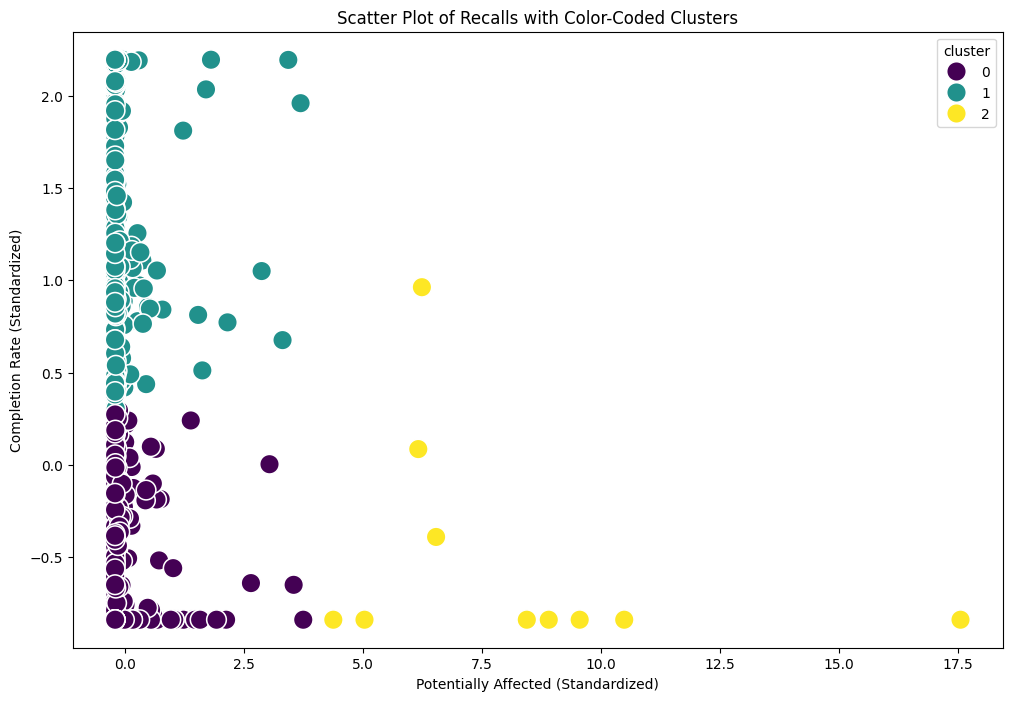

In [80]:
plt.figure(figsize=(12, 8))

scatter = sns.scatterplot(x='potentially_affected', y='completion_rate', hue='cluster', data=df, palette='viridis', s=200)

plt.title('Scatter Plot of Recalls with Color-Coded Clusters')
plt.xlabel('Potentially Affected (Standardized)')
plt.ylabel('Completion Rate (Standardized)')
plt.show()

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


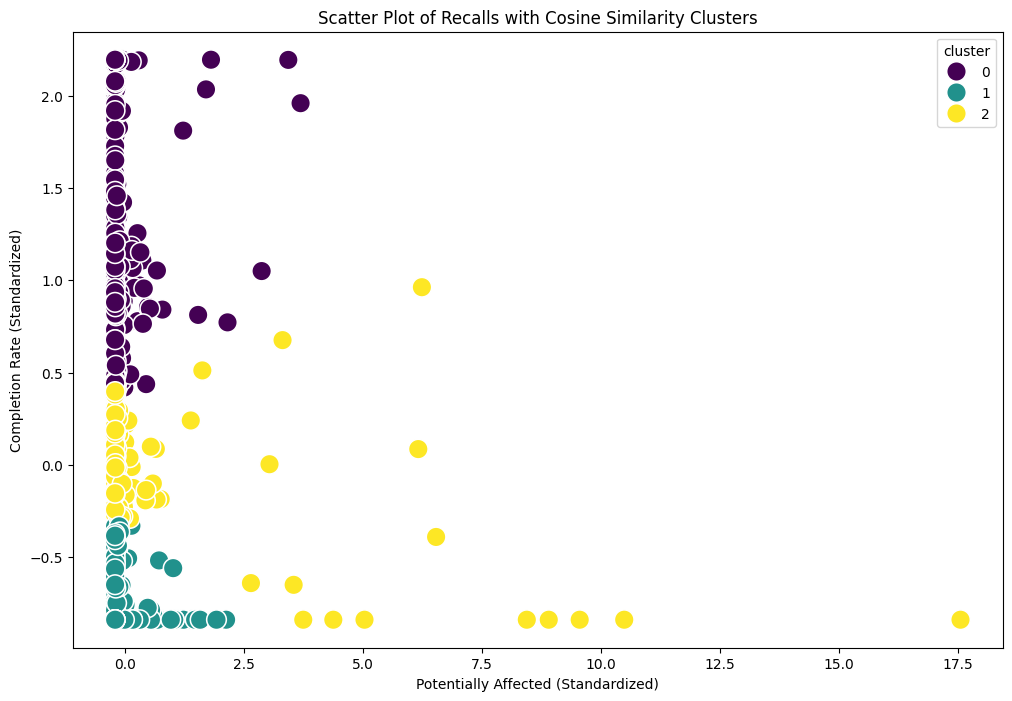

In [84]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = ['potentially_affected', 'completion_rate', 'risk_score']
numeric_transformer = StandardScaler()

# One-Hot Encoding for categorical features
categorical_features = ['manufacturer', 'component']
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X = preprocessor.fit_transform(df)


cosine_sim_matrix = cosine_similarity(X)


num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(cosine_sim_matrix)

plt.figure(figsize=(12, 8))


scatter = sns.scatterplot(x='potentially_affected', y='completion_rate', hue='cluster', data=df, palette='viridis', s=200)


plt.title('Scatter Plot of Recalls with Cosine Similarity Clusters')
plt.xlabel('Potentially Affected (Standardized)')
plt.ylabel('Completion Rate (Standardized)')
plt.show()

In [ ]:
df